# Jacobson Forecast Analysis, Historic

What are the mean election outcomes for each of the qualitative bins, and how uncertain are they?

In [6]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

# https://medium.com/@dustinmichels/three-handy-jupyter-notebook-snippets-dcb2f8ddc7db
import sys; sys.path.insert(0, '..')
from election_meta import models as m

In [8]:
# Should be available through 2010/2011
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/20403
state_pre = pd.read_csv('./data/states/Partisan_Balance_For_Use2011_06_09b.csv')

# Copy for use in frequency analysis below
election_frequency = state_pre.copy()

state_pre = state_pre[['year', 'election_year', 'state', 'sen_dem_per_2pty', 'hs_dem_per_2pty']]
state_pre = state_pre.rename(
    columns={
        'sen_dem_per_2pty': 'dem_senate_seatshare',
        'hs_dem_per_2pty': 'dem_house_seatshare'
    }
)
# Second dataset begins at 2009
state_pre = state_pre.query('year < 2009')
state_pre
# 462 rows have null values, across a range of years, keep for now,
# or use left join of election forecasts
# state_pre[state_pre.isnull().any(1)]

,year,election_year,state,dem_senate_seatshare,dem_house_seatshare
0,1939,1938,Alabama,100.0,99.0566
1,1940,1939,Alabama,100.0,99.0566
2,1941,1940,Alabama,100.0,99.0566
3,1942,1941,Alabama,100.0,99.0566
4,1943,1942,Alabama,100.0,99.0566
...,...,...,...,...,...
4085,1935,1934,Wisconsin,NaN,NaN
4086,1936,1935,Wisconsin,NaN,NaN
4092,1934,1933,Wyoming,NaN,NaN
4093,1935,1934,Wyoming,NaN,NaN


In [9]:
twoparty = pd.read_csv('./data/states/state_legislative_control_2009_2021.csv')
twoparty = twoparty.query('state != "Nebraska"') # Nonpartisan
twoparty = twoparty.astype({'senate_dem': float, 'senate_rep': float, 'house_dem': float, 'house_rep': float})
twoparty.eval('dem_senate_seatshare = 100*senate_dem/(senate_dem+senate_rep)', inplace=True) 
twoparty.eval('dem_house_seatshare = 100*house_dem/(house_dem+house_rep)', inplace=True)
twoparty = twoparty[['state', 'year', 'dem_senate_seatshare', 'dem_house_seatshare']]
twoparty['election_year'] = twoparty['year'] - 1

# Combine
twoparty = pd.concat([state_pre, twoparty])
twoparty

,year,election_year,state,dem_senate_seatshare,dem_house_seatshare
0,1939,1938,Alabama,100.000000,99.056600
1,1940,1939,Alabama,100.000000,99.056600
2,1941,1940,Alabama,100.000000,99.056600
3,1942,1941,Alabama,100.000000,99.056600
4,1943,1942,Alabama,100.000000,99.056600
...,...,...,...,...,...
645,2021,2020,Virginia,53.846154,55.000000
646,2021,2020,Washington,59.183673,58.163265
647,2021,2020,West Virginia,32.352941,23.000000
648,2021,2020,Wisconsin,37.500000,38.775510


In [11]:
# Pivot for combining with Jacobson
twoparty = pd.melt(
    twoparty,
    id_vars = ['year', 'election_year', 'state'],
    value_vars =['dem_senate_seatshare', 'dem_house_seatshare'],
    var_name = 'chamber',
    value_name = 'dem_twoparty_seatshare'
)

twoparty['chamber'] = twoparty['chamber'].replace(
    ['dem_senate_seatshare', 'dem_house_seatshare'],
    ['senate', 'house']
)
twoparty

,year,election_year,state,chamber,dem_twoparty_seatshare
0,1939,1938,Alabama,senate,100.000000
1,1940,1939,Alabama,senate,100.000000
2,1941,1940,Alabama,senate,100.000000
3,1942,1941,Alabama,senate,100.000000
4,1943,1942,Alabama,senate,100.000000
...,...,...,...,...,...
8769,2021,2020,Virginia,house,55.000000
8770,2021,2020,Washington,house,58.163265
8771,2021,2020,West Virginia,house,23.000000
8772,2021,2020,Wisconsin,house,38.775510


In [12]:
# Jacobson state forecasts
state_forecasts = pd.read_csv('./data/jacobson/Jacobson_Forecasts_2002_2020.tab', sep='\t')
state_forecasts.rename(
    columns={
        'forecastyear': 'year', 'forecastmonth': 'month', 'forecastday': 'day',
        'electionyear': 'election_year'
    },
    inplace=True
)
state_forecasts['date'] = pd.to_datetime(state_forecasts[['year', 'month', 'day']])

# Select last forecast for each location, chamber, year
state_forecasts = state_forecasts.sort_values(
    by='date'
).groupby(
    ['state', 'chamber', 'year']
).tail(1)

state_forecasts = state_forecasts[
    ~state_forecasts['jacobsonforecast'].isin(
        ['NO ELECTIONS', 'Unicameral legislature', 'Non-partisan']
    )
]
state_forecasts = state_forecasts[
    ['state', 'chamber', 'year', 'election_year', 'jacobsonforecast',
    'jacobsonforecastnumeric', 'date']
]
state_forecasts

,state,chamber,year,election_year,jacobsonforecast,jacobsonforecastnumeric,date
0,Alabama,senate,2002.0,2002.0,Safe D,7,2002-10-04
72,Oregon,senate,2002.0,2002.0,Toss-up,4,2002-10-04
71,Oklahoma,house,2002.0,2002.0,Toss-up,4,2002-10-04
70,Oklahoma,senate,2002.0,2002.0,Safe D,7,2002-10-04
69,Ohio,house,2002.0,2002.0,Safe R,1,2002-10-04
...,...,...,...,...,...,...,...
2428,Iowa,senate,2020.0,2020.0,Likely R,2,2020-07-22
2427,Indiana,house,2020.0,2020.0,Safe R,1,2020-07-22
2426,Indiana,senate,2020.0,2020.0,Safe R,1,2020-07-22
2424,Illinois,senate,2020.0,2020.0,Safe D,7,2020-07-22


In [13]:
state_forecasts = state_forecasts.merge(
    twoparty[['election_year', 'state', 'chamber', 'dem_twoparty_seatshare']],
    on=['election_year', 'state', 'chamber'],
    how='left'
)
state_forecasts['jacobsonforecastnumeric'] = state_forecasts['jacobsonforecastnumeric'].astype(float)
state_forecasts = state_forecasts.sort_values(by='jacobsonforecastnumeric', ascending=True)
state_forecasts

,state,chamber,year,election_year,jacobsonforecast,jacobsonforecastnumeric,date,dem_twoparty_seatshare
866,Wyoming,house,2020.0,2020.0,Safe R,1.0,2020-07-22,12.068966
356,North Dakota,house,2010.0,2010.0,Safe R,1.0,2010-11-01,26.595745
355,North Dakota,senate,2010.0,2010.0,Safe R,1.0,2010-11-01,25.531915
352,Indiana,senate,2008.0,2008.0,Safe R,1.0,2008-10-15,34.000000
348,Kansas,senate,2008.0,2008.0,Safe R,1.0,2008-10-15,22.500000
...,...,...,...,...,...,...,...,...
340,Massachusetts,house,2008.0,2008.0,Safe D,7.0,2008-10-15,89.937107
338,Minnesota,house,2008.0,2008.0,Safe D,7.0,2008-10-15,64.925373
335,Connecticut,senate,2008.0,2008.0,Safe D,7.0,2008-10-15,66.666667
703,Oregon,senate,2018.0,2018.0,Safe D,7.0,2018-10-08,60.000000


In [32]:
def pr_close(series):
    counts = len(series[series.between(47.5, 52.5)])
    return counts/len(series)

def CI80_lower(series):
    #return np.percentile(series, [2.5, 97.5])[0]
    return np.percentile(series, [10, 90])[0]

def CI80_upper(series):
    #return np.percentile(series, [2.5, 97.5])[1]
    return np.percentile(series, [10, 90])[1]

summary = state_forecasts.groupby(
    by=['jacobsonforecastnumeric', 'jacobsonforecast']
).agg(
    {'dem_twoparty_seatshare':['mean', 'std', pr_close, CI80_lower, CI80_upper]}
)

summary.columns = summary.columns.droplevel(0)
summary = summary.reset_index(drop=False)
summary.to_csv('./data/output/jacobson_category_summary.csv', index=False)

# Output table for blog
summary_fmt = summary.copy()
summary_fmt.set_index('jacobsonforecast', inplace=True)
summary_fmt.drop(['jacobsonforecastnumeric'], inplace=True, axis=1)
# col_subset = list(summary_fmt)
# col_subset.remove('jacobsonforecast')
summary_fmt = summary_fmt.style.format(
    "{:.2f}", subset=col_subset
)
m.output_table(summary_fmt, './data/output/jacobson_bins.html')
summary_fmt

,mean,std,pr_close,CI80_lower,CI80_upper
jacobsonforecast,,,,,
Safe R,28.70,9.08,0.00,15.99,40.32
Likely R,38.83,6.44,0.02,30.00,45.90
Lean R,42.85,6.44,0.14,35.68,50.63
Toss-up,50.39,6.22,0.38,41.67,58.19
Lean D,55.59,5.38,0.21,49.25,63.27
Likely D,58.61,5.87,0.05,51.93,64.86
Safe D,72.25,10.88,0.00,60.00,87.50


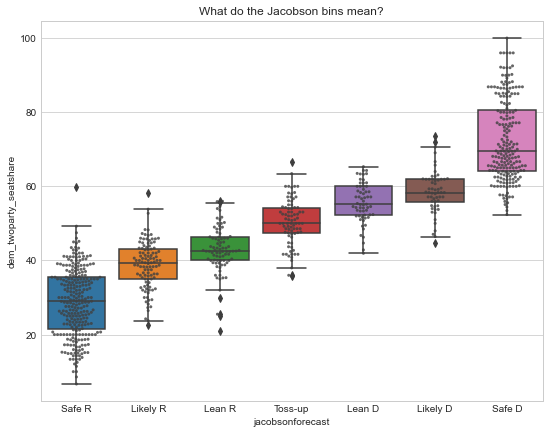

In [23]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.set_title('What do the Jacobson bins mean?')
sns.boxplot(
    data=state_forecasts, x='jacobsonforecast',
    y='dem_twoparty_seatshare', ax=ax
)
sns.swarmplot(
    data=state_forecasts, x='jacobsonforecast', y='dem_twoparty_seatshare',
    color=".25", size=3, alpha=0.8, ax=ax
)
plt.savefig('./data/output/jacobson_bins.png', bbox_inches='tight')
plt.show()

# Bootstrapping Estimates

Bootstrapped results don't differ much from the simple aggregated summary above.

In [16]:
# Use resampling to estimate the param
# https://allendowney.github.io/ElementsOfDataScience/12_bootstrap.html
# Honestly, no need to do this, the summed values are extremely close to
# the bootstrapped values, this doesn't really add anything, although
# it shows there isn't much uncertainty in the resulting mean values.

def bootstrap_values(forecast_bin, df, varname, n):
    rows = []
    for i in range(n):
        bootstrapped = df.sample(n=len(df), replace=True)
        mean = bootstrapped[varname].mean()
        pr_close = len(bootstrapped.query('47.5 <= dem_twoparty_seatshare <= 52.5'))/len(df)
        stdev = bootstrapped[varname].std()
        ci_low, ci_high = np.percentile(bootstrapped[varname], [10, 90])
        rows.append([forecast_bin, mean, stdev, pr_close, ci_low, ci_high])
    # Take mean of all summary statistics
    results = pd.DataFrame(
        rows,
        columns = ['jacobsonforecastnumeric','mean', 'stdev', 
            'pr_close', 'ci_low', 'ci_high']
    )
    results = results.mean()
    return results

def bootstrap_categories(state_forecasts):
    
    results = []
    for i in state_forecasts['jacobsonforecastnumeric'].drop_duplicates():
        temp = state_forecasts.query('jacobsonforecastnumeric == @i')
        i_result = bootstrap_values(i, temp, 'dem_twoparty_seatshare', n=1000)
        results.append(i_result)
    results_df = pd.concat(results, axis=1).T
    return results_df

In [17]:
bootstrapped_summary = bootstrap_categories(state_forecasts)
bootstrapped_summary

,jacobsonforecastnumeric,mean,stdev,pr_close,ci_low,ci_high
0,1.0,28.712906,9.070151,0.003926,16.269966,40.186970
1,2.0,38.812578,6.398832,0.019103,30.300355,46.017883
2,3.0,42.847850,6.403082,0.138047,35.969403,50.786742
3,4.0,50.358605,6.174715,0.376732,41.872326,58.177129
4,5.0,55.567365,5.308266,0.216279,48.989840,62.470838
5,6.0,58.595564,5.775374,0.052875,51.586711,65.066913
6,7.0,72.257173,10.864212,0.004981,60.232983,87.635878


# State Election Frequencies

I year adjust the potential power values by electin frequency in the main model, so this snippet just calculates those values for each of the state legislatures. 

In [30]:
sen_frequency = election_frequency[
    ['election_year', 'state',
     'sen_elections_this_year']
].copy()
sen_frequency.query('sen_elections_this_year == 1.0', inplace=True)
sen_frequency = sen_frequency.sort_values(by='election_year', ascending=True)
sen_frequency.query('election_year > 2000', inplace=True)
sen_frequency.reset_index(drop=True, inplace=True)
sen_frequency['election_frequency'] = sen_frequency[
    ['state', 'election_year']
].groupby(by='state').diff(1)
# diff = sen_frequency[['state', 'election_year']].groupby(by='state').diff(1)
# diff
# Get most recent
sen_frequency = sen_frequency.groupby(by='state').tail(1)
sen_frequency = sen_frequency[['state', 'election_frequency']]
sen_frequency['branch'] = 'statesenate'

hs_frequency = election_frequency[
    ['election_year', 'state',
     'hs_elections_this_year']
].copy()
hs_frequency.query('hs_elections_this_year == 1.0', inplace=True)

hs_frequency = hs_frequency.sort_values(by='election_year', ascending=True)
hs_frequency.query('election_year > 2000', inplace=True)
hs_frequency.reset_index(drop=True, inplace=True)
hs_frequency['election_frequency'] = hs_frequency[
    ['state', 'election_year']
].groupby(by='state').diff(1)
# Get most recent
hs_frequency = hs_frequency.groupby(by='state').tail(1)
hs_frequency = hs_frequency[['state', 'election_frequency']]
hs_frequency['branch'] = 'statehouse'

# fed_frequency = pd.DataFrame({
#     'branch': ['president', 'ushouse', 'ussenate', 'governors'],
#     'state': ['', '', '', ''],
#     'election_frequency': [4, 2, 2, 4]
# })

freq = pd.concat([sen_frequency, hs_frequency])
freq.reset_index(drop=True, inplace=True)
freq.to_csv('data/states/election_frequencies.csv', index=False)
freq

,state,election_frequency,branch
0,New Jersey,4.0,statesenate
1,Louisiana,4.0,statesenate
2,Mississippi,4.0,statesenate
3,Virginia,4.0,statesenate
4,Kansas,4.0,statesenate
...,...,...,...
94,Maine,2.0,statehouse
95,Maryland,4.0,statehouse
96,Massachusetts,2.0,statehouse
97,Hawaii,2.0,statehouse
